<a href="https://colab.research.google.com/github/jindaldisha/Deep-Learning-and-Neural-Networks/blob/main/02_2_logistic_regression_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Logistic Regression with PyTorch



We'll solve an image classification problem. The dataset used is the `MNIST Handwritten Digits Database`. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. 

In [1]:
#Import Libraries
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

##Import Data



The dataset consists of tuple consisting of a 28x28 image and its label. Originally the image are an object of class `PIL.Image.Image, which is a part of the Python imaging library Pillow. We need to convert the images into tensors as PyTorch doesn't work with images. We can do this by specifying a transform while creating our dataset.

In [53]:
#Download training and test dataset (it is going to download inside 'data' directory and creates a PyTorch Dataset)
dataset = MNIST(root='data/', download = True, train = True, transform = transforms.ToTensor())
test_dataset = MNIST(root='data/', train=False, transform = transforms.ToTensor())

In [3]:
#Check size of the dataset
len(dataset), len(test_dataset)

(60000, 10000)

The training dataset has 60,000 images that we'll use to train our model. And the testing dataset has 10,000 images that we'll use for testing and evaluation purposes.

In [4]:
#Look at a sample dataset element
image, label = dataset[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

The images have been converted to a `1x28x28` tensors. The first dimension tracks the color channels. The second and third dimension represents pixels along the height and width of the image respectively. Since the dataset we're using has only grayscale image, there is only one color channel. 

In [5]:
#Range of pixel values
print('Max Value of Pixel: ', torch.max(image).item())
print('Min Value of Pixel: ', torch.min(image).item())

Max Value of Pixel:  1.0
Min Value of Pixel:  0.0


The pixel values range from 0 to 1, representing black and white respectively. And the value in between different shades of grey. 

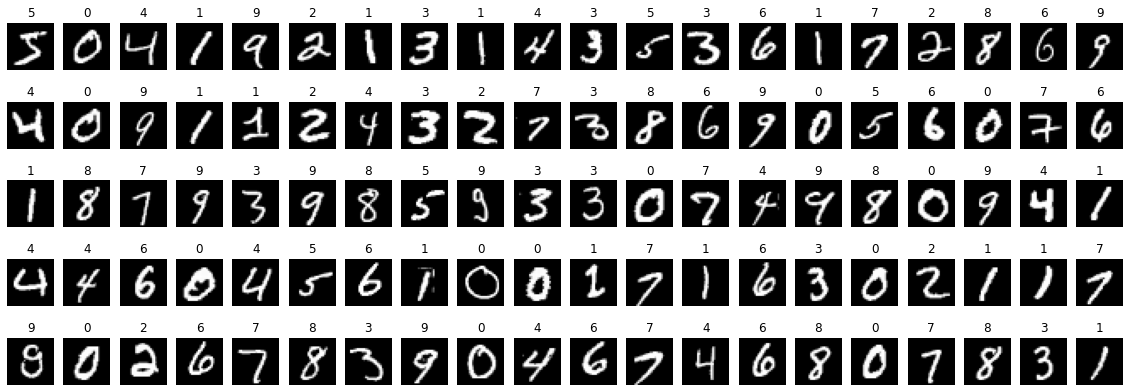

In [6]:
#Plot multiple sample images
plt.figure(figsize=(20,7))
# plt.subplots_adjust(hspace=0.4, wspace=0.5)
for i in range(100):
  plt.subplot(5,20,i+1)
  image, label = dataset[i]
  #We pass only the 28x28 matrix and exclude the color channel
  plt.imshow(image[0,:,:], cmap='gray')
  plt.title(label)
  plt.axis(False)

## Training and Validation Datasets



While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

It is essential to choose a random sample for creating a validation set. Training data is often sorted by target labels. If we create a validation set using consecutive images, it would consist of similar images. Such training and validation datasets would make it impossible to train a useful model.

In [7]:
train_dataset, validation_dataset = random_split(dataset, [50000, 10000])
len(train_dataset), len(validation_dataset)

(50000, 10000)

When working with large datasets, its not possible to train the entire dataset at once as it may not fit into the memory and even if it does, the entire process will be very slow. And therefore what we do instead is take the dataset and break it into batches and train our model batch by batch.

We'll also create a `DataLoader`, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data.

We can set the `shuffle = True` in `DataLoader`. This helps randomize the input to optimization algorithm, leading to a faster reduction in loss. This also helps in generalization i.e. it helps in improving the performace of the model on data it has never seen before.

In [8]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size) #data is already shuffled in validation dataset

##Model

- A logistic regression model contains weights and bias matrices and the output is obtained using `y_pred = x @ w.t() + b`.
-The learning part of a logistic regression is to figure out the weights (w11, w12..) and the biases (b1, b2..) using the training data and make accurate predictions for the test data that we pass to it. 
-We train our model by adjusting the weights and biases slighty many time and keep improving our accuracy. To improve our model, we use an optimization technique called Gradient Descent.
-The learned weights will be used to get an output for each image. We get a vector of size 10 (since there are 10 output classes), with each element signifying the probability of a particular target label (0 to 9). The predicted label for an image is simply the one with the highest probability.  
- We'll be using `nn.Linear` to create our model. Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is flattened into a vecotor of size `784 (1*28*28)` before being passed into the model.



In [9]:
#Define values
input_size = 28*28
classes = 10

- In `__init__` constructor, we instantiate weights and biases using nn.Linear.
- Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. Inside `forward` method, we flatten the input image tensors and pass it to `self.linear`.

In [10]:
#Model class
class Model(nn.Module):
  def __init__(self):
    #Call the constructor of nn.Module class
    super().__init__()
    self.linear = nn.Linear(input_size, classes) #Add a linear layer
    
  def forward(self, xb):
    xb = xb.reshape(-1, input_size)
    out = self.linear(xb)
    return out

In [11]:
#Create a model
model = Model()

In [12]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [65]:
print(model.linear.weight.shape, model.linear.bias.shape)

torch.Size([10, 784]) torch.Size([10])


PyTorch bundles all the weights and biases of all the layers in our model into `.parameters()`

In [13]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0116, -0.0177,  0.0129,  ...,  0.0317,  0.0111,  0.0175],
         [ 0.0013,  0.0118,  0.0145,  ..., -0.0129, -0.0211, -0.0002],
         [ 0.0021,  0.0222,  0.0088,  ...,  0.0264,  0.0311, -0.0345],
         ...,
         [ 0.0169, -0.0070, -0.0115,  ..., -0.0225, -0.0354, -0.0243],
         [-0.0038, -0.0172, -0.0056,  ...,  0.0070, -0.0187,  0.0146],
         [ 0.0005,  0.0299,  0.0075,  ..., -0.0276,  0.0185,  0.0163]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0177, -0.0188, -0.0168, -0.0085, -0.0195,  0.0181,  0.0287, -0.0075,
          0.0289,  0.0019], requires_grad=True)]

In [14]:
#Test our model on a single batch
for images, labels in train_loader:
  outputs = model(images)
  break
outputs.shape

torch.Size([128, 10])

In [15]:
outputs[0]

tensor([ 0.0933, -0.1218,  0.1041, -0.0736,  0.0264,  0.1204,  0.3071,  0.4152,
         0.2901, -0.1625], grad_fn=<SelectBackward>)

For each input image, we get a vector of 10 values, one for each class. We need these outputs to represent probabilities. Each output must lie between 0 to 1 and add up to 1. To convert the output row into probabilities, we use the softmax function.

In [16]:
#Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

In [17]:
probs[0], torch.sum(probs[0]).item()

(tensor([0.0977, 0.0788, 0.0988, 0.0827, 0.0914, 0.1004, 0.1210, 0.1348, 0.1189,
         0.0756], grad_fn=<SelectBackward>), 0.9999999403953552)

We can determine the predicted label for each image by choosing the index of the element with the highest probability in each output row. We can use `torch.max`, which returns each row's largest element and its corresponding index.

In [18]:
#(maximum probablity value, index)
max_probs, preds = torch.max(probs, dim=1)

In [19]:
#Predicted Labels
preds

tensor([7, 7, 7, 7, 8, 7, 7, 7, 5, 7, 7, 3, 7, 8, 7, 7, 7, 5, 7, 7, 8, 1, 8, 7,
        7, 8, 8, 8, 8, 7, 7, 5, 8, 7, 7, 7, 7, 7, 7, 5, 5, 7, 7, 8, 5, 8, 7, 7,
        7, 7, 7, 8, 5, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 6, 7, 5, 7, 5, 7, 5, 8, 7,
        5, 3, 7, 7, 7, 5, 7, 7, 7, 8, 5, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 8, 7, 8,
        7, 5, 7, 7, 8, 8, 7, 7, 7, 5, 7, 7, 7, 7, 8, 7, 3, 8, 7, 5, 7, 8, 8, 5,
        8, 7, 3, 1, 7, 7, 7, 7])

In [20]:
#True Labels
labels

tensor([8, 9, 7, 8, 9, 5, 9, 1, 1, 0, 9, 0, 7, 7, 6, 8, 0, 5, 1, 1, 0, 8, 1, 6,
        8, 0, 3, 8, 0, 7, 3, 8, 1, 8, 8, 9, 7, 5, 1, 5, 7, 7, 1, 3, 1, 8, 3, 9,
        8, 5, 9, 1, 6, 3, 1, 9, 9, 7, 2, 6, 6, 1, 9, 6, 1, 3, 7, 7, 1, 3, 9, 4,
        3, 7, 7, 4, 1, 9, 1, 1, 0, 6, 3, 3, 9, 9, 1, 5, 4, 0, 2, 9, 9, 2, 2, 0,
        7, 7, 7, 9, 7, 1, 1, 8, 2, 8, 4, 9, 0, 7, 7, 1, 0, 7, 7, 7, 4, 8, 2, 1,
        6, 8, 5, 2, 6, 7, 7, 6])

In [21]:
#Number of correct predictions
(torch.sum(preds == labels)).item()

20

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

##Evaluation Metric, Loss Function and Optimizer

Before we make changes in our model to improve our predictions, we need a way to evaluate our model. We can do this by finding the percentage of labels that were predicted corrected i.e. the accuracy of the predictions.

In [22]:
def accuracy(outputs, labels):
  max_probs, preds = torch.max(outputs, dim=1)
  num_of_equal = torch.sum(preds == labels).item()
  len_of_preds = len(preds)
  percentage = torch.tensor(num_of_equal/len_of_preds)
  return percentage

In [23]:
#Calculate Accuracy
accuracy(outputs, labels)

tensor(0.1562)

`Accuracy` can be used as an `evaluation metrics` but it cannot be used as a `loss function` with gradient descent. This is because of the fact that accuracy is a non-differentiable and non-continuous function. And therefore it cannot be used to compute gradients w.r.t. weights and biases. It also doesn't take into account the actual probabilities predicted by the model so it cannot provide sufficient feedback for incremental improvements.

In classification problems, we use `cross-entropy` as a loss function.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model ( a slightly higher probability for the correct label leads to a lower loss).

Also `cross-entropy` performs `softmax` internally, therefore we can directly pass to it the outputs from our model.

In [24]:
#Loss Function
loss_function = F.cross_entropy

In [25]:
#Loss for current batch
loss = loss_function(outputs, labels)
print('Loss: ', loss.item())

Loss:  2.281456232070923


Cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training examples. It just means the predicted probability of the correct label is e^(-loss). The lower the loss, the higher thr probability of the correct label and the better the model.

Instead of manually manipulating the model's weights & biases using gradients, we can use the optimizer `optim.SGD`. SGD is short for "stochastic gradient descent". The term stochastic indicates that samples are selected in random batches instead of as a single group.

`model.parameters()` is passed as an argument to `optim.SGD` so that the optimizer knows which matrices should be modified during the update step. Also, we can specify a learning rate that controls the amount by which the parameters are modified.

The increase or decrease in the loss by changing a weight element is proportional to the gradient of the loss w.r.t. that element. This observation forms the basis of the gradient descent optimization algorithm that we'll use to improve our model (by descending along the gradient).

We can subtract from each weight element a small quantity proportional to the derivative of the loss w.r.t. that element to reduce the loss slightly.

In simple words, if the gradient is negative, the slope is negative so we need to increase the weight. If the gradient is positive, the slope is positive so we need to decrease the weight.

It is called gradient descent, because we're descending along the gradient.

In [26]:
#Define the Optimizer Function
optimizer_function = torch.optim.SGD

##Redefine Model

- In `__init__` constructor, we instantiate weights and biases using nn.Linear.
- Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. Inside `forward` method, we flatten the input image tensors and pass it to `self.linear`.
- In `training_step` method, we first generate predictions and then using these predictions and true labels, we calculate the loss.
- In `validation_step` method, we first generate predictions and then using these predictions and true labels, we calculate loss and accuracy.
- In `validation_epoch_end` method, we take the mean of accuracy and loss for an epoch.
- In `epoch_end` method, we simply print the average accuracy and loss for an epoch that we calculated in `validation_epoch_end`.

In [32]:
#Model class
class Model(nn.Module):
  def __init__(self):
    #Call the constructor of nn.Module class
    super().__init__()
    self.linear = nn.Linear(input_size, classes) #Add a linear layer
    
  def forward(self, xb):
    xb = xb.reshape(-1, input_size)
    out = self.linear(xb)
    return out

  def training_step(self, batch):
    images, labels = batch
    preds = self(images) #Make Predictions
    loss = F.cross_entropy(preds, labels) #Calculate Loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    preds = self(images)  #Make Predictions
    loss = F.cross_entropy(preds, labels) #Calculate loss
    acc = accuracy(preds, labels) #Calculate Accuracy
    step_eval = {'val_loss': loss, 'val_acc': acc} 
    return step_eval

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    epoch_val = {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    return epoch_val
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = Model()

##Training the model

So far we've created:
- Data loaders
- The model
- Loss Function
- Optimizers

Now the next step is to train the model. We have a training phase and a validation phase for every epoch.

Steps (for every epoch):
- Training Phase (for every batch)
  - Load the batch
    - Generate predictions
    - Calculate loss
    - Compute gradients
    - Update weights
    - Reset gradients
- Validation Phase (for every batch)
  - Load the batch
    - Generate predictions
    - Calculate loss
    - Calculate metrics (accuracy, etc.)
- Calculate  average validation loss and metrics

- Log epoch, loss and metrics for inspection

The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time.

In [36]:
#Function to fit the model to the data
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
  #Define optimizer
  optimizer = opt_func(model.parameters(), lr)
  history = [] #to record result every epoch
  for epoch in range(epochs):
    #Training Phase
    for batch in train_loader:
      #Calculate loss
      loss = model.training_step(batch)
      #Compute gradients
      loss.backward()
      #Update parameters using gradients
      optimizer.step()
      #Reset gradients to zero
      optimizer.zero_grad()

    #Validation Phase
    result = evaluate(model, val_loader) #Calculate average loss and accuracy for every epoch
    model.epoch_end(epoch, result) #Print the result every epoch
    history.append(result) #Save the result in history every epoch
  return history

In [29]:
#evalute function returns the average loss and everage accuracy for validation dataset.
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader] 
  return model.validation_epoch_end(outputs)

In [33]:
#Initial performance of model on validation set without training it
history0 = evaluate(model, validation_loader)
history0

{'val_acc': 0.12005537748336792, 'val_loss': 2.3112998008728027}

When we call the fit function to fit the model to the data, for each epoch, we are getting batches from training dataloader `train_loader` and validation data loader `validation_loader`. These batches contain a set of images and a set of labels. We pass them onto the model. The model then envokes the `forward` function. WHich first reshapes the images into the shape `(batch_size, input_size)`. Then this batch of reshaped images is passed into the the layers that we've defined in the `__init__` constructor. In this case we only have one single linear layer which has one weights and one bias matrix. The image vector gets multiplied with the weights matrix and then we add the biases based on `x @ w.t() + b`. `w` has the shape of `(output_size, input_size)`, and `b` has a shape of `(output_size)`. In this case since there are 10 classes, we get an output vector containing 10 elements, each element representing the value corresponding to that index class. We then take these predicted values and compare them with the true labels by first performing `softmax`, which basically converts the predicted values to probabilities. Then we use `cross-entropy`. It is the negative logarithm of the predicted probability of the correct label averaged over all training examples. It just means the predicted probability of the correct label is e^(-loss). The lower the loss, the higher thr probability of the correct label and the better the model.
Then in order to reduce the loss, we perform `gradient descent`. And then update the weights and biases to improve the model. Then we load the `validation_dataloader` and run it throught the model batch by batch to get the losses and accuracies. Then we take the mean of all the losses and accuracies for each epoch to evaluate how our model is performing.

In [37]:
#Training model for 5 epochs
history1 = fit(5, 0.001, model, train_loader, validation_loader, optimizer_function)

Epoch [0], val_loss: 1.9431, val_acc: 0.6161
Epoch [1], val_loss: 1.6754, val_acc: 0.7350
Epoch [2], val_loss: 1.4751, val_acc: 0.7730
Epoch [3], val_loss: 1.3239, val_acc: 0.7863
Epoch [4], val_loss: 1.2078, val_acc: 0.7999


In [38]:
#Training for 20 more epochs
history2 = fit(20, 0.001, model, train_loader, validation_loader, optimizer_function)

Epoch [0], val_loss: 1.1167, val_acc: 0.8056
Epoch [1], val_loss: 1.0437, val_acc: 0.8134
Epoch [2], val_loss: 0.9840, val_acc: 0.8185
Epoch [3], val_loss: 0.9343, val_acc: 0.8222
Epoch [4], val_loss: 0.8924, val_acc: 0.8253
Epoch [5], val_loss: 0.8565, val_acc: 0.8284
Epoch [6], val_loss: 0.8253, val_acc: 0.8319
Epoch [7], val_loss: 0.7980, val_acc: 0.8352
Epoch [8], val_loss: 0.7740, val_acc: 0.8366
Epoch [9], val_loss: 0.7525, val_acc: 0.8399
Epoch [10], val_loss: 0.7333, val_acc: 0.8414
Epoch [11], val_loss: 0.7159, val_acc: 0.8440
Epoch [12], val_loss: 0.7001, val_acc: 0.8460
Epoch [13], val_loss: 0.6856, val_acc: 0.8477
Epoch [14], val_loss: 0.6724, val_acc: 0.8496
Epoch [15], val_loss: 0.6603, val_acc: 0.8513
Epoch [16], val_loss: 0.6491, val_acc: 0.8530
Epoch [17], val_loss: 0.6386, val_acc: 0.8541
Epoch [18], val_loss: 0.6289, val_acc: 0.8552
Epoch [19], val_loss: 0.6199, val_acc: 0.8560


In [47]:
#Training for 20 more epochs
history3 = fit(20, 0.001, model, train_loader, validation_loader, optimizer_function)

Epoch [0], val_loss: 0.6114, val_acc: 0.8572
Epoch [1], val_loss: 0.6033, val_acc: 0.8587
Epoch [2], val_loss: 0.5959, val_acc: 0.8595
Epoch [3], val_loss: 0.5889, val_acc: 0.8616
Epoch [4], val_loss: 0.5822, val_acc: 0.8624
Epoch [5], val_loss: 0.5758, val_acc: 0.8633
Epoch [6], val_loss: 0.5698, val_acc: 0.8642
Epoch [7], val_loss: 0.5641, val_acc: 0.8654
Epoch [8], val_loss: 0.5587, val_acc: 0.8661
Epoch [9], val_loss: 0.5535, val_acc: 0.8668
Epoch [10], val_loss: 0.5486, val_acc: 0.8678
Epoch [11], val_loss: 0.5439, val_acc: 0.8688
Epoch [12], val_loss: 0.5394, val_acc: 0.8701
Epoch [13], val_loss: 0.5351, val_acc: 0.8709
Epoch [14], val_loss: 0.5310, val_acc: 0.8713
Epoch [15], val_loss: 0.5271, val_acc: 0.8720
Epoch [16], val_loss: 0.5232, val_acc: 0.8729
Epoch [17], val_loss: 0.5195, val_acc: 0.8733
Epoch [18], val_loss: 0.5160, val_acc: 0.8747
Epoch [19], val_loss: 0.5126, val_acc: 0.8752


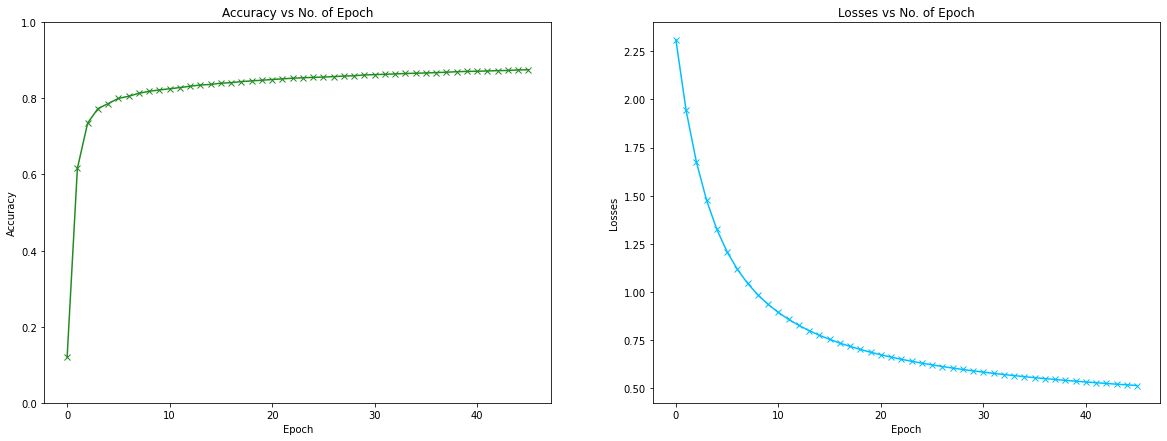

In [50]:
#Visualize history
history = [history0] + history1 + history2 + history3
accuracies = [result['val_acc'] for result in history]
losses = [result['val_loss'] for result in history]
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(accuracies, marker='x', c='forestgreen', ls='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Accuracy vs No. of Epoch')
plt.subplot(1,2,2)
plt.plot(losses, marker='x', c='deepskyblue', ls='-')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.title('Losses vs No. of Epoch');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. 

The more likely reason that the model just isn't powerful enough. In our initail hypothesis, we have assumed that the output (in this case the class probabilities) is a linear function of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. 

From the logitic regression model that we create, we get an accuracy of around `87%` in 45 epochs, and since the progress seems to be stagnant, we need to introduce non-linearity to the model as stated above that the relationship between the pixel intensities and the digit that it represents is not linear.

##Testing

In [55]:
#Function to predict label for a single image
def predict_image(img, model):
  xb = img.unsqueeze(0) #add another dimesion at the beginning since it is a single image
  yb = model(xb)
  maxprob, preds = torch.max(yb, dim = 1)
  return preds[0].item()

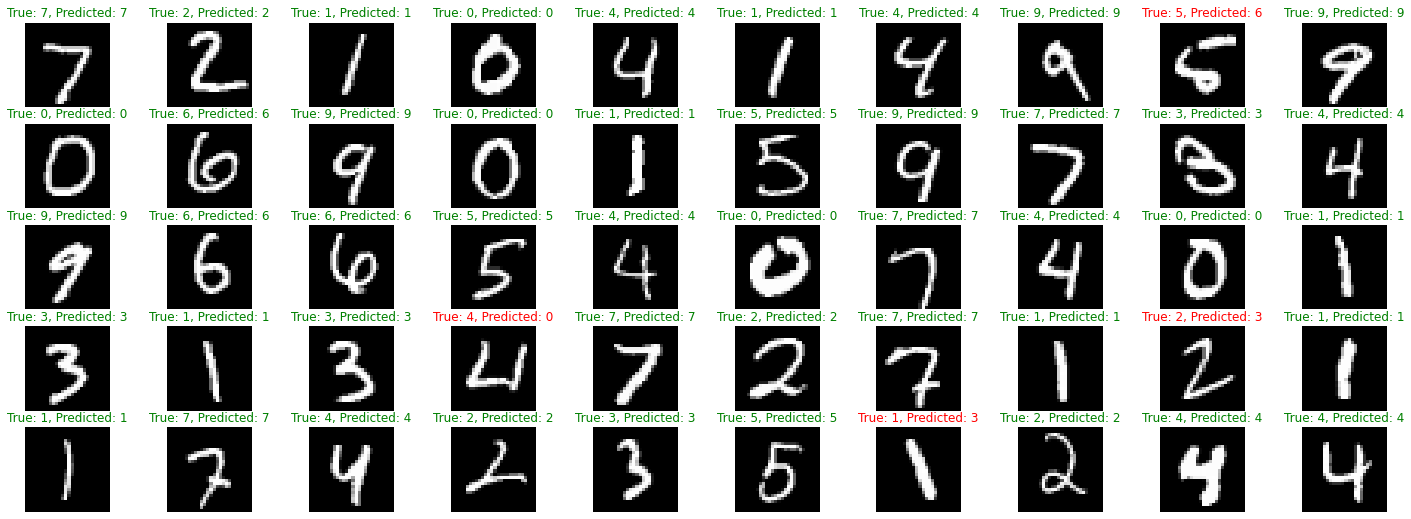

In [67]:
#Test on multiple images
plt.figure(figsize=(25,9))
# plt.subplots_adjust(hspace=0.4, wspace=0.5)
for i in range(50):
  plt.subplot(5,10,i+1)
  image, label = test_dataset[i]
  #We pass only the 28x28 matrix and exclude the color channel
  plt.imshow(image[0,:,:], cmap='gray')
  predicted_label = predict_image(image,model)
  if predicted_label == label:
    plt.title(f'True: {label}, Predicted: {predicted_label}', color='g')
  else:
    plt.title(f'True: {label}, Predicted: {predicted_label}', color='r')
  plt.axis(False)

In [62]:
#Overal Loss and Accuracy of the model on test set
test_loader = DataLoader(test_dataset, batch_size = 128)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8800435066223145, 'val_loss': 0.4842875599861145}

The accuracy of our model on the test dataset is around `88%`.

The accuract of our model on the test and train dataset is pretty similar. 

##Saving the Model

In [63]:
#Saving the model
torch.save(model.state_dict(), 'mnist-logistic-model.pth')

`.state_dict` returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.


In [64]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0316, -0.0356,  0.0079,  ...,  0.0271, -0.0128,  0.0185],
                      [-0.0109, -0.0040, -0.0139,  ...,  0.0305, -0.0309,  0.0139],
                      [-0.0106, -0.0073,  0.0023,  ..., -0.0163,  0.0047,  0.0322],
                      ...,
                      [ 0.0228,  0.0286, -0.0208,  ..., -0.0325, -0.0179, -0.0286],
                      [ 0.0356, -0.0184,  0.0057,  ..., -0.0130, -0.0341,  0.0157],
                      [-0.0087,  0.0210, -0.0126,  ...,  0.0327,  0.0206, -0.0124]])),
             ('linear.bias',
              tensor([-0.0508,  0.1438, -0.0162, -0.0411,  0.0402,  0.1164, -0.0248,  0.0808,
                      -0.1760, -0.0403]))])